# Visualizing Commodity Trade Statistics Using Azure, Python

In [1]:
from azure.storage.blob import BlockBlobService
from azure.storage.blob import ContentSettings
import os
import uuid
from io import StringIO
import pandas as pd

block_blob_service = BlockBlobService(account_name='<enter account name>', account_key='<enter account key>')


blobstring = block_blob_service.get_blob_to_text('mycontainer', 'commodity.csv').content
df = pd.read_csv(StringIO(blobstring), low_memory=False)

df.head(5)

,country_or_area,year,comm_code,commodity,flow,trade_usd,weight_kg,quantity_name,quantity,category
0,Afghanistan,2016,010410,"Sheep, live",Export,6088,2339.0,Number of items,51.0,01_live_animals
1,Afghanistan,2016,010420,"Goats, live",Export,3958,984.0,Number of items,53.0,01_live_animals
2,Afghanistan,2008,010210,"Bovine animals, live pure-bred breeding",Import,1026804,272.0,Number of items,3769.0,01_live_animals
3,Albania,2016,010290,"Bovine animals, live, except pure-bred breeding",Import,2414533,1114023.0,Number of items,6853.0,01_live_animals
4,Albania,2016,010392,"Swine, live except pure-bred breeding > 50 kg",Import,14265937,9484953.0,Number of items,96040.0,01_live_animals


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
df.describe()

,year,trade_usd,weight_kg,quantity
count,8.225871e+06,8.225871e+06,8.097396e+06,7.921014e+06
mean,2.004768e+03,9.505370e+07,3.556503e+07,2.671470e+08
std,7.037779e+00,7.074154e+09,2.479277e+09,3.739231e+11
min,1.988000e+03,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.999000e+03,1.107200e+04,1.089000e+03,1.062000e+03
50%,2.005000e+03,1.534160e+05,2.689800e+04,2.712000e+04
75%,2.011000e+03,1.895476e+06,4.474432e+05,4.623620e+05
max,2.016000e+03,2.443311e+12,1.860133e+12,1.026357e+15


In [4]:
commodities = pd.concat([df['commodity'].str.split(', ', expand=True)], axis=1)

In [5]:
new_df = pd.concat([df,commodities], axis = 1)
new_df = new_df.rename(columns={0:'commodity1', 1:'commodity2', 2:'commodity3', 3:'commodity4', 4:'commodity5', 5:'commodity6', 6:'commodity7'})

#### Number of categories for each variable

In [6]:
categories = pd.DataFrame(new_df.nunique())
categories.columns = ['No. of Categories']

In [7]:
categories

,No. of Categories
country_or_area,209
year,29
comm_code,5040
commodity,5031
flow,4
trade_usd,3062165
weight_kg,2137907
quantity_name,12
quantity,2124833
category,98


In [101]:
new_df.quantity_name.unique()

array(['Number of items', 'No Quantity', 'Weight in kilograms',
       'Volume in litres', 'Length in metres', 'Area in square metres',
       'Electrical energy in thousands of kilowatt-hours',
       'Volume in cubic meters', 'Number of pairs', 'Thousands of items',
       'Weight in carats', 'Number of packages'], dtype=object)

#### Number of missing values in each column

In [8]:
missing_values = pd.DataFrame(new_df.isna().sum())
missing_values.columns = ['No. of missing values']

In [9]:
missing_values

,No. of missing values
country_or_area,0
year,0
comm_code,0
commodity,0
flow,0
trade_usd,0
weight_kg,128475
quantity_name,0
quantity,304857
category,0


### Top importers and exporters overall in terms of Trade in USD

In [46]:
# new_df.groupby(['country_or_area']).groups.keys()
# df['country_or_area'].count()
flow_analysis = new_df.groupby(['country_or_area', 'flow']).sum().reset_index()
flow_analysis = flow_analysis.drop(['year'], axis=1)

In [47]:
flowdata = new_df.groupby(['country_or_area','flow']).sum().reset_index()
flowdata = flowdata[flowdata['flow'].isin(flow_list)]
flowdata.trade_usd = round(flowdata.trade_usd/(10**9)).astype('int')
flow_list = ['Export', 'Import']

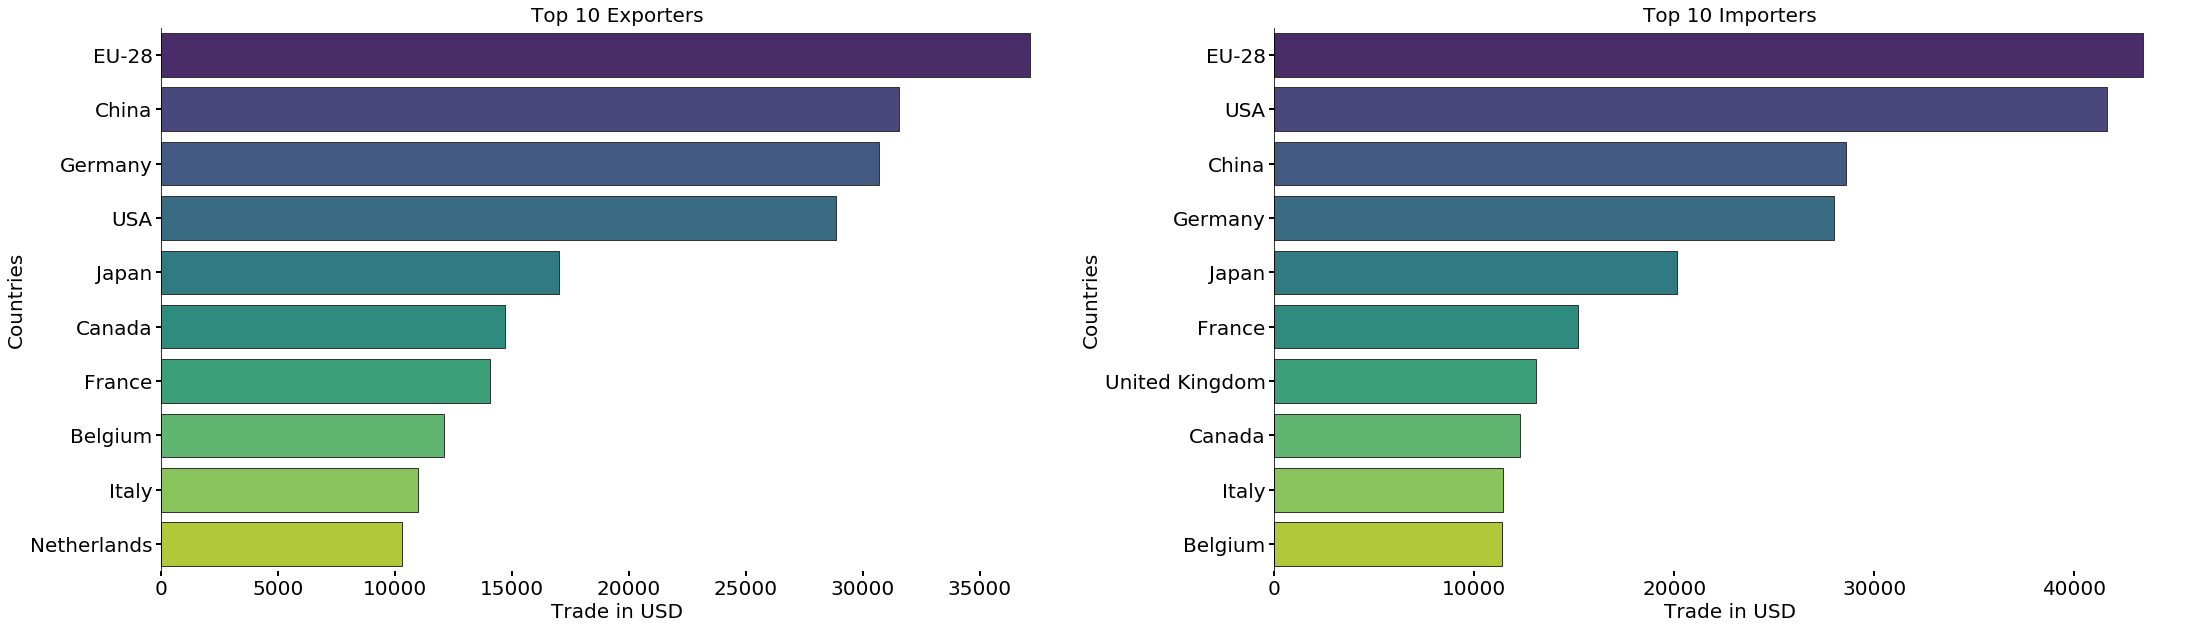

In [42]:
data = []
for i in flow_list:
    temp = flowdata[flowdata.flow ==i].sort_values(by ='trade_usd',ascending=False)
    data.append(temp.head(10))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
axes = [ax1,ax2]
for k in range(len(axes)):
    sns.barplot(x = 'trade_usd',y='country_or_area',data=data[k],palette = 'viridis', ax=axes[k],edgecolor=".2")
    axes[k].set_title('Top 10 '+flow_list[k]+'ers',fontsize=20)
    axes[k].set_xlabel('Trade in USD', fontsize = 20)
    axes[k].set_ylabel('Countries', fontsize = 20)
    kwargs = {'length':5,'width':2,'color':'black','labelsize':20}
    axes[k].tick_params(**kwargs)
    x_axis = axes[k].axes.get_xaxis().set_visible(True)
    sns.despine(bottom=True)
    f.subplots_adjust(wspace=0.22,right= 2,hspace=0.4)
plt.show()


### Year-wise Exports and Imports

#### Trade in USD 

In [64]:
yearwise_flow = new_df.groupby(['year', 'flow']).agg(sum).reset_index()

Text(0.5, 0, 'Year')

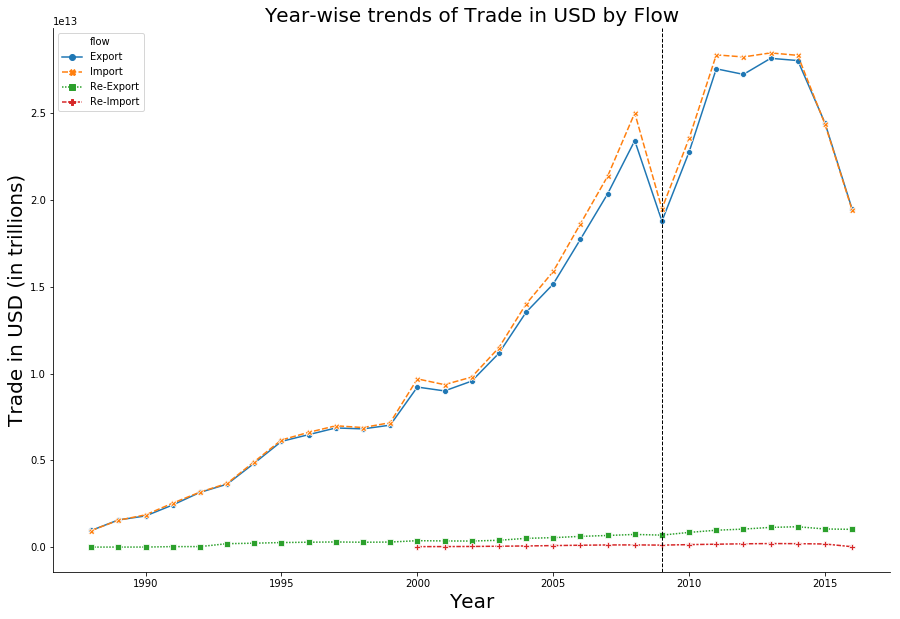

In [94]:
f,ax = plt.subplots(figsize=(15,10))
sns.lineplot(x = 'year', y = 'trade_usd', hue = 'flow', style = 'flow', markers = True, data = yearwise_flow)
sns.despine(bottom=False)
ax.axvline(x = 2009, color = 'black', linestyle = '--', linewidth = 1)
ax.set_title('Year-wise trends of Trade in USD by Flow',fontsize=20)
ax.set_ylabel('Trade in USD (in trillions)', fontsize = 20)
ax.set_xlabel('Year', fontsize = 20)


#### Weight in kg

Text(0.5, 0, 'Year')

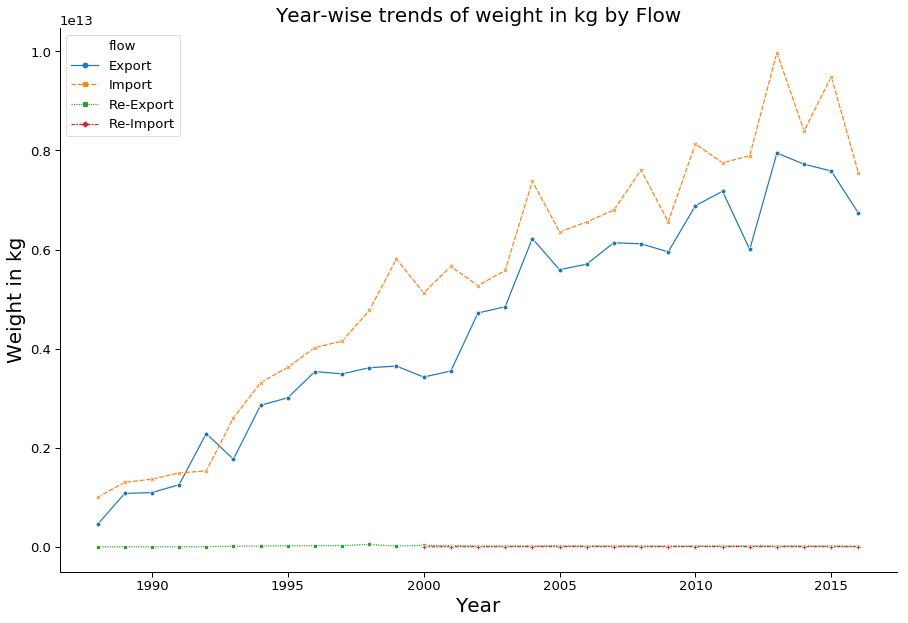

In [158]:
f,ax = plt.subplots(figsize=(15,10))
sns.lineplot(x = 'year', y = 'weight_kg', hue = 'flow', style = 'flow', markers = True, data = yearwise_flow)
sns.despine(bottom=False)
# ax.axvline(x = 2009, color = 'black', linestyle = '--', linewidth = 1)
ax.set_title('Year-wise trends of weight in kg by Flow',fontsize=20)
ax.set_ylabel('Weight in kg', fontsize = 20)
ax.set_xlabel('Year', fontsize = 20)

### Country-wise exports and imports 

#### Based on Quantity

In [136]:
countrywise_flow_quantity = new_df[new_df.quantity_name == 'Number of items'].groupby(['country_or_area', 'flow']).agg(sum).reset_index()
countrywise_flow_quantity = countrywise_flow_quantity.sort_values(['quantity'],ascending=False)


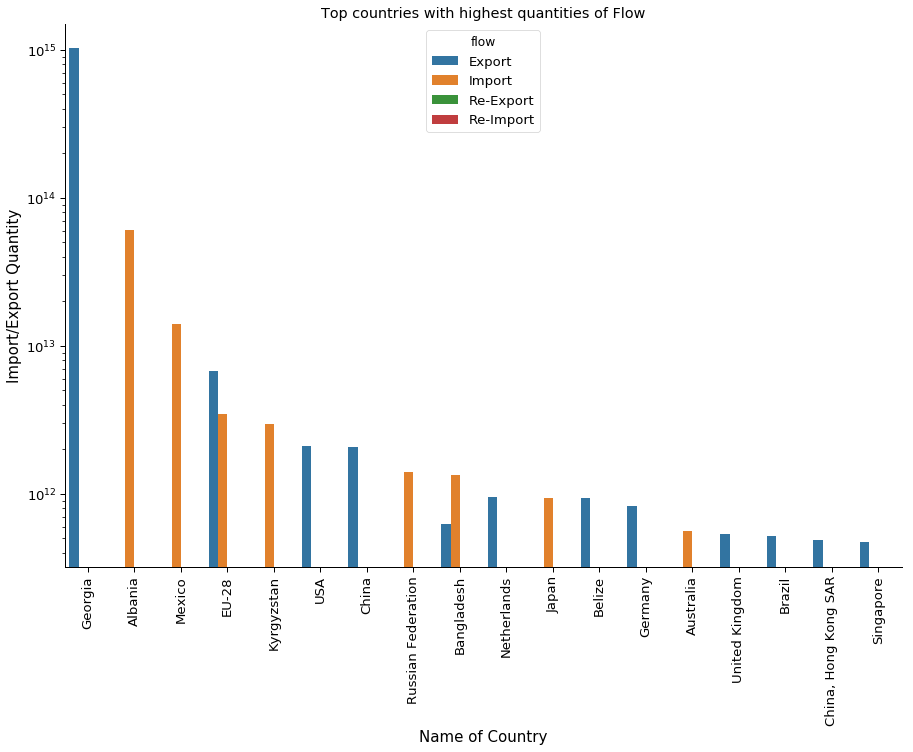

In [137]:
f, ax = plt.subplots(figsize=(15,10))

sns.barplot(x=countrywise_flow_quantity["country_or_area"].head(20), y=countrywise_flow_quantity['quantity'].head(20), hue = 'flow', data=countrywise_flow_quantity)
sns.despine(bottom=False)

ax.set_yscale('log')
ax.set_xlabel("Name of Country",fontsize=15)
ax.set_ylabel("Import/Export Quantity (on log scale)",fontsize=15)
ax.set_title('Top countries with highest quantities of Flow')
for item in ax.get_xticklabels():
    item.set_rotation(90)

#### Based on Weight

In [138]:
countrywise_flow_weight = new_df.groupby(['country_or_area', 'flow']).agg(sum).reset_index()
countrywise_flow_weight = countrywise_flow_weight.sort_values(['weight_kg'],ascending=False)


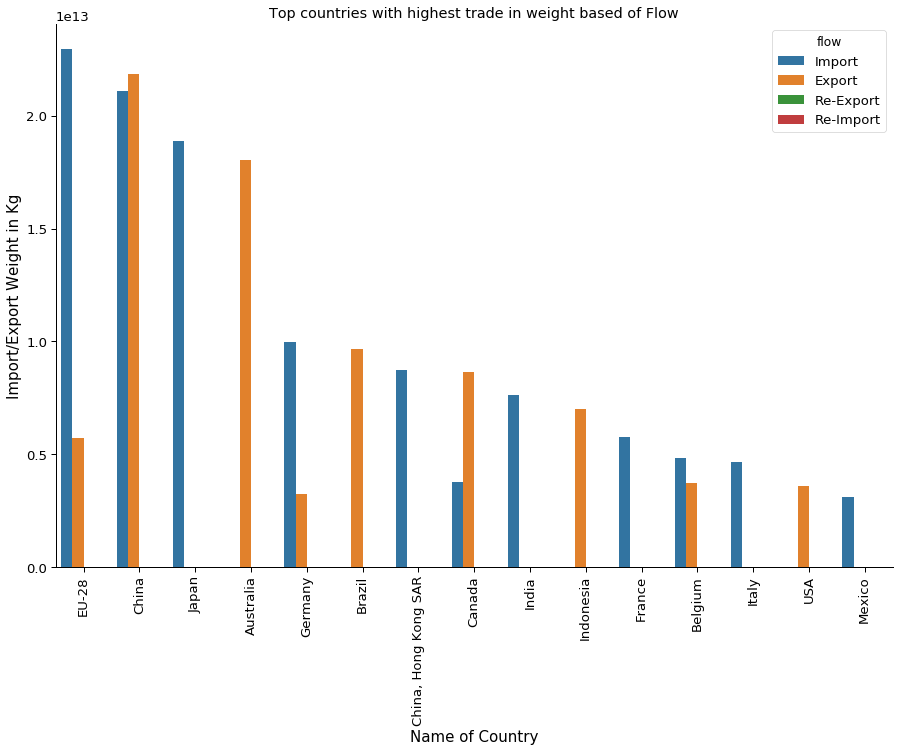

In [140]:
f, ax = plt.subplots(figsize=(15,10))

sns.barplot(x=countrywise_flow_weight["country_or_area"].head(20), y=countrywise_flow_weight['weight_kg'].head(20), hue = 'flow', data=countrywise_flow_weight)
sns.despine(bottom=False)

# ax.set_yscale('log')
ax.set_xlabel("Name of Country",fontsize=15)
ax.set_ylabel("Import/Export Weight in Kg",fontsize=15)
ax.set_title('Top countries with highest trade in weight based of Flow')
for item in ax.get_xticklabels():
    item.set_rotation(90)

#### Based on trade in USD

In [143]:
countrywise_flow_trade = new_df.groupby(['country_or_area', 'flow']).agg(sum).reset_index()
countrywise_flow_trade = countrywise_flow_trade.sort_values(['trade_usd'],ascending=False)


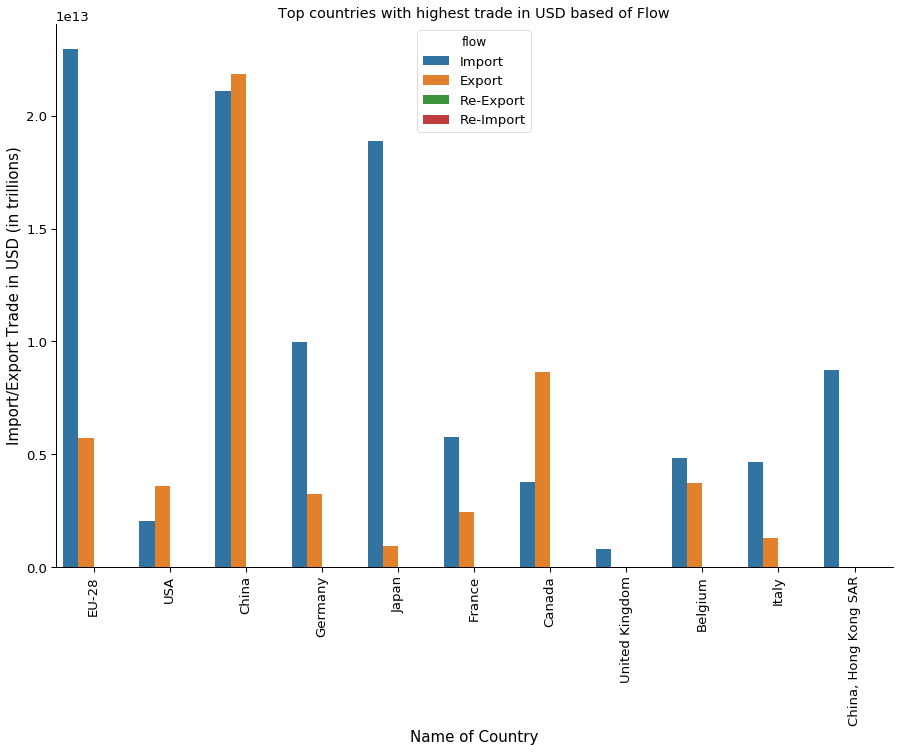

In [145]:
f, ax = plt.subplots(figsize=(15,10))

sns.barplot(x=countrywise_flow_trade["country_or_area"].head(20), y=countrywise_flow_trade['weight_kg'].head(20), hue = 'flow', data=countrywise_flow_trade)
sns.despine(bottom=False)

# ax.set_yscale('log')
ax.set_xlabel("Name of Country",fontsize=15)
ax.set_ylabel("Import/Export Trade in USD (in trillions)",fontsize=15)
ax.set_title('Top countries with highest trade in USD based of Flow')
for item in ax.get_xticklabels():
    item.set_rotation(90)

#### Comparision of trade among top countries 

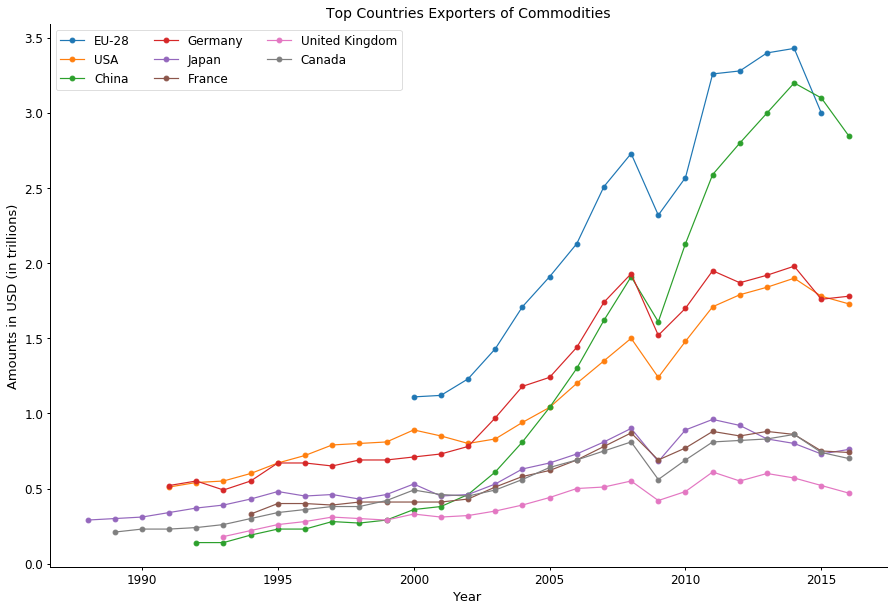

In [156]:
data = new_df.groupby(['country_or_area','year','flow']).sum().reset_index()
ctry_list = ['EU-28', 'USA', 'China','Germany','Japan','France', 'United Kingdom', 'Canada']

data = data[data['country_or_area'].isin(ctry_list)]

data.trade_usd = round((data.trade_usd/(10**12)),2).astype('float')

f, ax = plt.subplots(figsize = (15, 10))
for i in range(8):
    data[(data.country_or_area==ctry_list[i]) & (data.flow==flow_list[0])].plot(kind = 'line',
                            x='year',y='trade_usd',marker='o',label = ctry_list[i],ax =ax)

# ax.axvline(x=2009, color='darkred',linestyle= '-',linewidth=3)
kwargs = {'fontsize':13,'color':'black'}
plt.xlabel('Year',**kwargs)
plt.ylabel('Amounts in USD (in trillions)',**kwargs)
# ax.set_yticklabels(['0','0.5T','1T','1.5T','2T','2.5T','3.5T'])
kg = {'length':3,'width':1,'color':'black','labelsize':12}
ax.tick_params(**kg)
sns.despine(bottom=False)
plt.title('Top Countries '+ flow_list[0]+'ers'+' of Commodities',fontsize=14)
plt.legend(loc='best',fontsize=12,ncol=3)
plt.show()


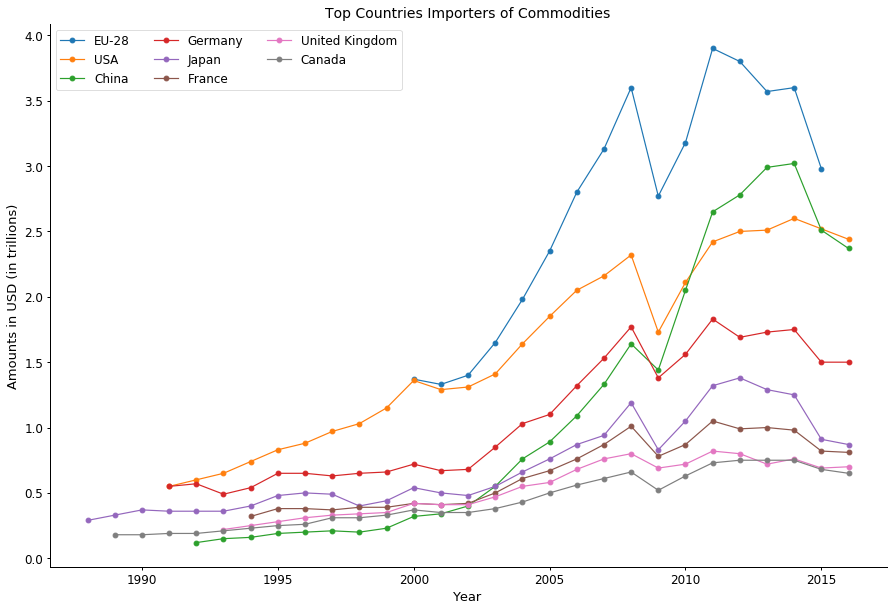

In [157]:
f, ax = plt.subplots(figsize = (15, 10))
for i in range(8):
    data[(data.country_or_area==ctry_list[i]) & (data.flow==flow_list[1])].plot(kind = 'line',
                            x='year',y='trade_usd',marker='o',label = ctry_list[i],ax =ax)

# ax.axvline(x=2009, color='darkred',linestyle= '-',linewidth=3)
kwargs = {'fontsize':13,'color':'black'}
plt.xlabel('Year',**kwargs)
plt.ylabel('Amounts in USD (in trillions)',**kwargs)
# ax.set_yticklabels(['0','0.5T','1T','1.5T','2T','2.5T','3.5T'])
kg = {'length':3,'width':1,'color':'black','labelsize':12}
ax.tick_params(**kg)
sns.despine(bottom=False)
plt.title('Top Countries '+ flow_list[1]+'ers'+' of Commodities',fontsize=14)
plt.legend(loc='best',fontsize=12,ncol=3)
plt.show()